## Import libraries

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(42)
import matplotlib as mpl
import matplotlib.pyplot as plt


## Path original dataset and new directories for splits

In [227]:
# Path to original dataset
data_dir = "animals10/versions/2/raw-img"

# New directories for splits
base_dir = "split_data"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

## Create splits (70% train, 15% validation, 15% test)
I coded this to split up the raw images into different sets; the train, validation, and test set. It removes the images from the raw images folder so the data is already split. It also translates the animals to english when creating the folders. I had to implement a check so that it skips this process, since it is a one time run.

In [ ]:
# Translation dictionary
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "horse": "cavallo", "elephant": "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"}

# Function to create split folders if they don't exist
def create_split_dirs():
    for split in [train_dir, val_dir, test_dir]:
        os.makedirs(split, exist_ok=True)
        for class_name in os.listdir(data_dir):
            # Translate folder names using the dictionary
            translated_name = translate.get(class_name, class_name)
            os.makedirs(os.path.join(split, translated_name), exist_ok=True)

# Check if train_dir is empty (split hasn't been done)
if not os.listdir(train_dir):
    create_split_dirs()
    classes = os.listdir(data_dir)

    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)
        images = os.listdir(class_path)
        translated_name = translate.get(class_name, class_name)
        train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
        val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

        # Move images to the translated folders
        for img in train_images:
            os.replace(os.path.join(class_path, img), os.path.join(train_dir, translated_name, img))
        for img in val_images:
            os.replace(os.path.join(class_path, img), os.path.join(val_dir, translated_name, img))
        for img in test_images:
            os.replace(os.path.join(class_path, img), os.path.join(test_dir, translated_name, img))

    print("Successfully split into train, validation, and test sets.")
else:
    print("Data split already exists. Skipping splitting step.")

# Validate the split
for split, path in [("Train", train_dir), ("Validation", val_dir), ("Test", test_dir)]:
    total = sum([len(files) for _, _, files in os.walk(path)])
    print(f"{split} set: {total} images")


Data split already exists. Skipping splitting step.
Train set: 18322 images
Validation set: 3926 images
Test set: 3931 images


## Load data

In [ ]:
batch_size = 16

# Generators for the sets
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

validation_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

test_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)


Found 18322 images belonging to 10 classes.
Found 3926 images belonging to 10 classes.
Found 3931 images belonging to 10 classes.


## CNN model

In [230]:
cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  # Change 2 to 10
])

# Compile the model
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn.summary()


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_63 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 128)            │    11,944,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,950,442 (45.59 MB)

 Trainable params: 11,950,442 (45.59 MB)

 Non-trainable params: 0 (0.00 B)

## Train the CNN

In [231]:

history = cnn.fit(
    train_generator,
    batch_size=batch_size,
    epochs=10,
    validation_data=validation_generator
)


Epoch 1/10
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 430s 373ms/step - accuracy: 0.2319 - loss: 2.3386 - val_accuracy: 0.3125 - val_loss: 1.9644
Epoch 2/10
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 525s 458ms/step - accuracy: 0.3836 - loss: 1.7857 - val_accuracy: 0.4396 - val_loss: 1.6179
Epoch 3/10
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 593s 517ms/step - accuracy: 0.4363 - loss: 1.6267 - val_accuracy: 0.4755 - val_loss: 1.5460
Epoch 4/10
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 470s 410ms/step - accuracy: 0.4661 - loss: 1.5407 - val_accuracy: 0.4720 - val_loss: 1.5147
Epoch 5/10
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 525s 458ms/step - accuracy: 0.4943 - loss: 1.4850 - val_accuracy: 0.5089 - val_loss: 1.4406
Epoch 6/10
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 497s 434ms/step - accuracy: 0.5140 - loss: 1.4259 - val_accuracy: 0.5232 - val_loss: 1.4194
Epoch 7/10
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 450s 393ms/step - accuracy: 0.5107 - loss: 1.4129 - val_accuracy: 0.5127 - val_loss: 1.4181
Epoch 8/10
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 525s 458ms/step - ac

## Evaluate on test set

In [235]:

score = cnn.evaluate(test_generator)
print('Total loss on Testing Set:', score[0])
print('Accuracy of Testing Set:', score[1])


246/246 ━━━━━━━━━━━━━━━━━━━━ 44s 177ms/step - accuracy: 0.5709 - loss: 1.2680
Total loss on Testing Set: 1.3887765407562256
Accuracy of Testing Set: 0.5428643822669983


## Predict and Display the results
Results of the predictions shown in "output.png" It displays model predictions on 5 images from each of the animal categories. The number of images per category can be changed on last line of the code.

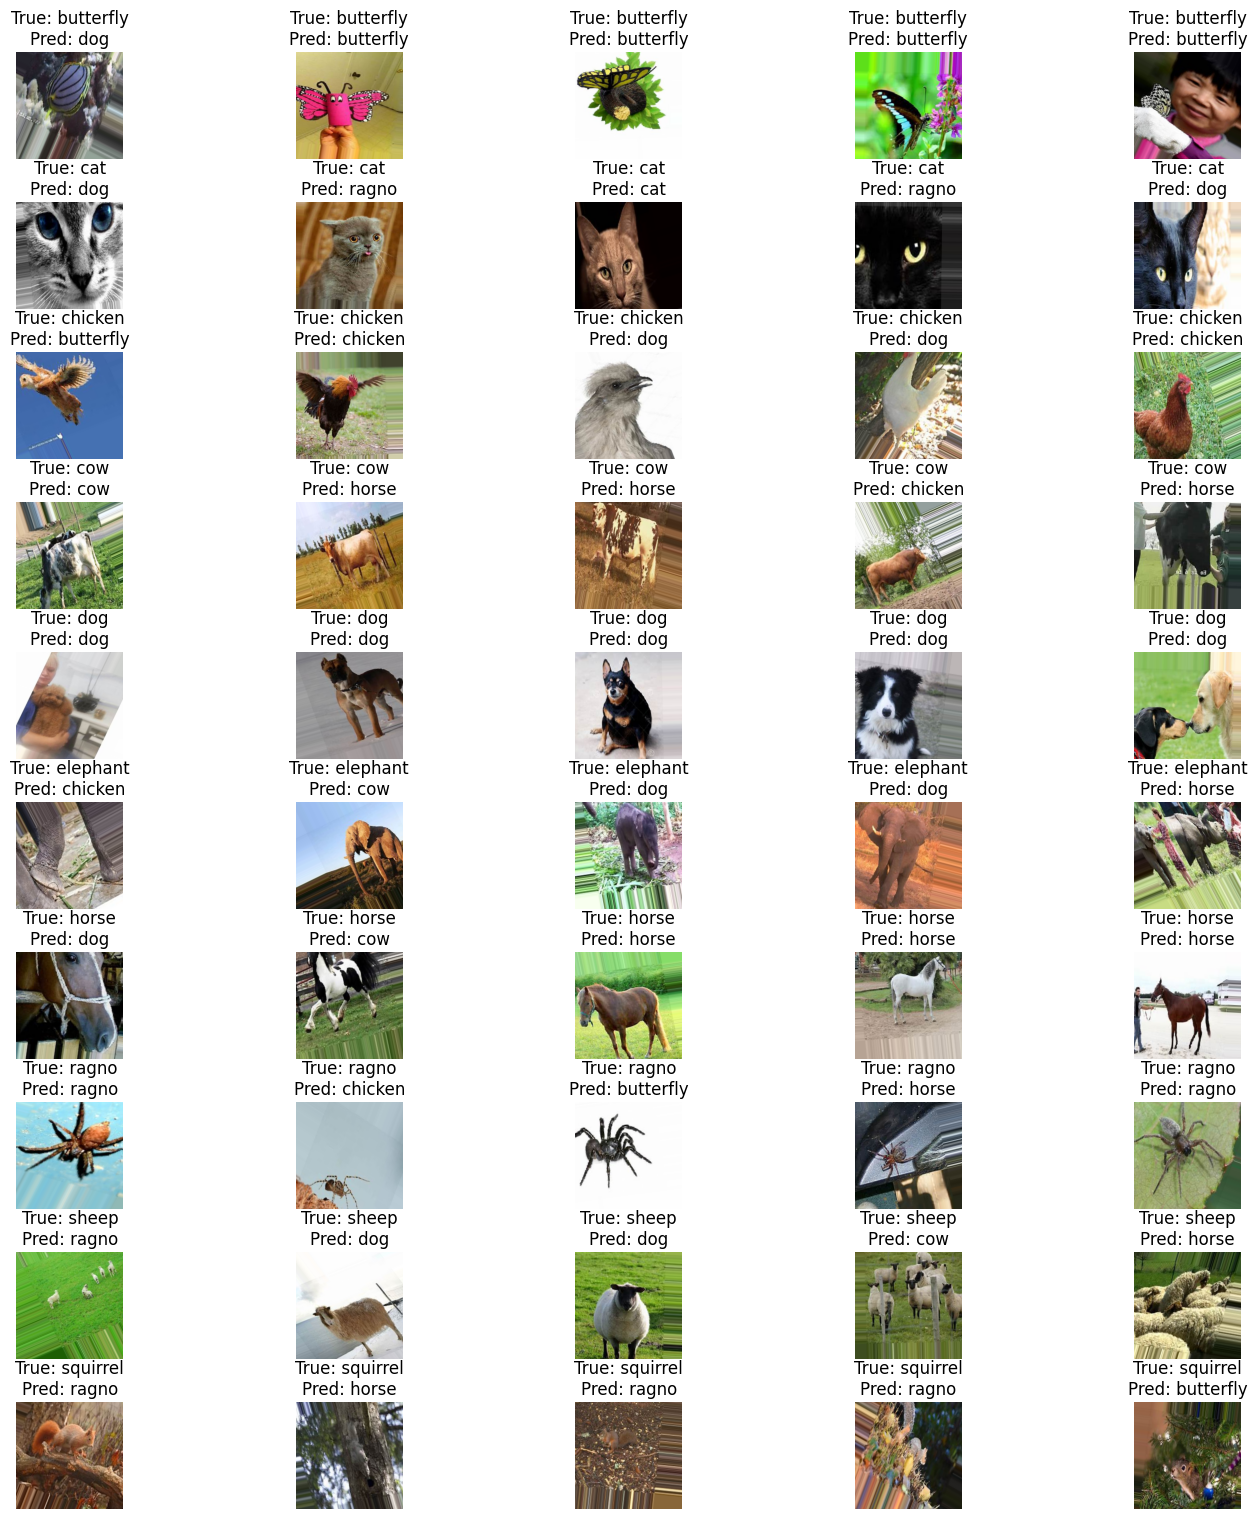

In [ ]:
def display_predictions(model, generator, class_names, num_per_class=2):
    class_images = {name: [] for name in class_names}

    # Loop through the generator to collect images for each class
    for images, labels in generator:
        # Predict on the batch
        predictions = model.predict(images, verbose=0)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(labels, axis=1)
        
        # Organize images by their true class
        for i in range(len(images)):
            true_label = class_names[true_classes[i]]
            if len(class_images[true_label]) < num_per_class:
                class_images[true_label].append((images[i], class_names[predicted_classes[i]]))
        
        if all(len(v) >= num_per_class for v in class_images.values()):
            break

    # Plot the images
    plt.figure(figsize=(15, 15))
    subplot_idx = 1
    for true_class, image_list in class_images.items():
        for img, pred_label in image_list:
            plt.subplot(len(class_names), num_per_class, subplot_idx)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"True: {true_class}\nPred: {pred_label}")
            subplot_idx += 1
    
    plt.tight_layout(pad=0)
    plt.show()

class_names = list(test_generator.class_indices.keys())
display_predictions(cnn, test_generator, class_names, num_per_class=5)
